In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from typing import List
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


In [2]:
df = pd.read_csv("Cervical_cancer_data_kag_cleaned.csv")
df.head()

,Unnamed: 0,Smokes,Hormonal Contraceptives,IUD,STDs,STDs:condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,...,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs: Number of diagnosis
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.0,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.0,5.0,16.0,4.0,37.0,37.0,3.0,0.0,0.0,0.0
4,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46.0,3.0,21.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          763 non-null    int64  
 1   Smokes                              763 non-null    float64
 2   Hormonal Contraceptives             763 non-null    float64
 3   IUD                                 763 non-null    float64
 4   STDs                                763 non-null    float64
 5   STDs:condylomatosis                 763 non-null    float64
 6   STDs:vaginal condylomatosis         763 non-null    float64
 7   STDs:vulvo-perineal condylomatosis  763 non-null    float64
 8   STDs:syphilis                       763 non-null    float64
 9   STDs:pelvic inflammatory disease    763 non-null    float64
 10  STDs:genital herpes                 763 non-null    float64
 11  STDs:molluscum contagiosum          763 non-n

In [4]:
def age_cat(age):
    if age < 12:
        return "Child"
    elif age < 20:
        return "Teens"
    elif age < 30:
        return "20s"
    elif age < 40:
        return "30s"
    elif age < 50:
        return "40s"
    elif age < 60:
        return "50s"
    else:
        return "Senior"

df['Age'] = df['Age'].astype(int)
df["age_cat"] = df['Age'].apply(age_cat)

In [5]:
df_binary = df.loc[:,df.nunique() <=2]
df_nonbinary = df.loc[:,df.nunique() > 2]
df_binary.shape,df_nonbinary.shape

((763, 22), (763, 12))

Dx:Cancer column has an imbalanced class. SMOTE will be used to deal with this problem.

In [6]:
X = df.drop(['Dx:Cancer','age_cat'], axis = 1)
y = df['Dx:Cancer'].copy()

The target variable, "Dx:Cancer" is imbalanced. We have to use SMOTE to oversample and balance the data.

In [7]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
df = X_smote.join(y_smote)
df['age_cat'] = df['Age'].apply(age_cat)

In [8]:
#standardizing the data
std = StandardScaler()
X = std.fit_transform(X)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state =42)


### Modeling

#### 1. Logistic Regression

In [10]:
C_param_range = [0.001,0.01,0.1,1]

lr_scores = pd.DataFrame(columns = ['C_parameter','Accuracy'])
lr_scores['C_parameter'] = C_param_range


j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    Logreg = LogisticRegression(penalty = 'l2', C = i,random_state = 40)
    Logreg.fit(X_train,y_train)
    
    # Predict using model
    y_pred_lr = Logreg.predict(X_test)
    
    # Saving accuracy score in table
    lr_scores.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
lr_scores   

,C_parameter,Accuracy
0,0.001,0.978166
1,0.010,0.991266
2,0.100,0.995633
3,1.000,0.995633


In [11]:
from sklearn.metrics import recall_score
param_grid = {'C': C_param_range}
logreg_cv = GridSearchCV(Logreg,param_grid, cv=5)
logreg_cv.fit(X_train,y_train)
y_pred_lr_cv = logreg_cv.predict(X_test)
accuracy_lr = accuracy_score(y_test,y_pred_lr_cv)
recall_lr = recall_score(y_test,y_pred_lr_cv)
print(accuracy_lr)
print(recall_lr)

0.9956331877729258
0.8


In [12]:
from sklearn.metrics import plot_confusion_matrix
cnf_matrix_lr = confusion_matrix(y_test, y_pred_lr_cv)

print(cnf_matrix_lr)

[[224   0]
 [  1   4]]


In [13]:
#checking training score
logreg_cv.score(X_train,y_train)

0.9925093632958801

In [14]:
#checking test scores
logreg_cv.score(X_test,y_test)

0.9956331877729258

#### 2. Random Forest

In [15]:
from sklearn.metrics import recall_score
rf = RandomForestClassifier(n_estimators=2500, max_leaf_nodes=2, n_jobs=-1,max_features="sqrt")

rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(accuracy_rf)

0.9781659388646288


#### 3. KNN classifier

In [16]:
knn_clf = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": list(np.arange(1, 100, 2))}
knn_clf_cv = GridSearchCV(knn_clf, knn_param_grid, cv=5,refit=True).fit(X_train,y_train)
knn_clf_cv = KNeighborsClassifier(**knn_clf_cv.best_params_)

In [17]:
knn_clf_cv.fit(X_train, y_train)
y_pred_knn = knn_clf_cv.predict(X_test)

accuracy_knn = accuracy_score(y_test,y_pred_knn)
print(accuracy_knn)

0.9956331877729258


#### 4. SVM 

In [18]:
svm_clf = SVC()
svc_param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), }
svm_clf_cv = GridSearchCV(svm_clf, svc_param_grid, cv=5)

In [19]:
svm_clf_cv.fit(X_train,y_train)
y_pred_svm = svm_clf_cv.predict(X_test)
accuracy_svm = accuracy_score(y_test,y_pred_svm)

print(accuracy_svm)

0.9912663755458515


#### 5. Gradient Boosting

In [20]:
gbc = GradientBoostingClassifier(subsample=0.8, learning_rate=0.05 , n_estimators=160, random_state=5, max_depth=9, max_leaf_nodes=100)
gbc.fit(X_train,y_train)
y_pred_gbc = gbc.predict(X_test)
accuracy_gbc = accuracy_score(y_test,y_pred_gbc)
print(accuracy_gbc)

0.9956331877729258


#### Model Fitting and Prediction

In [23]:
col_names = ["Classifier Name", "Accuracy Score", "Precision Score",
             "Recall Score", "F1 Score"]
summary_df = pd.DataFrame(columns=col_names)

est_name = []
est_acc = []
precision_score = []
recall_score = []
f1score = []
est_conf_matrix = []

estimators = [
    ("LogisticRegression", logreg_cv),
    ("RandomForestClassifier ", rf),
    ("KNeighborsClassifier", knn_clf_cv),
    ("SupportVectorClassifier", svm_clf_cv),
    ("Gradient Boosting Classifier",gbc)]

for i in range(0, len(estimators)):
    clf = estimators[i][1]
    clf_name = estimators[i][0]
    y_pred = clf.predict(X_test)
    est_name.append(estimators[i][0])
    est_acc.append(accuracy_score(y_test, y_pred))
    scores = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    precision_score.append(scores[0])
    recall_score.append(scores[1])
    f1score.append(scores[2])
    est_conf_matrix.append(confusion_matrix(y_test,y_pred))    

summary_df[col_names[0]] = est_name
summary_df[col_names[1]] = est_acc
summary_df[col_names[2]] = precision_score
summary_df[col_names[3]] = recall_score
summary_df[col_names[4]] = f1score

print(summary_df)


                Classifier Name  Accuracy Score  Precision Score  \
0            LogisticRegression        0.995633         0.995653   
1       RandomForestClassifier         0.978166         0.956809   
2          KNeighborsClassifier        0.995633         0.995653   
3       SupportVectorClassifier        0.991266         0.991344   
4  Gradient Boosting Classifier        0.995633         0.995653   

   Recall Score  F1 Score  
0      0.995633  0.995395  
1      0.978166  0.967369  
2      0.995633  0.995395  
3      0.991266  0.990194  
4      0.995633  0.995395  


C:\Users\Soumyadip\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [24]:
color_scales = ["agsunset","teal","purp","viridis","ice"]
for i in range(0,len(est_conf_matrix)):
    heatmap = px.imshow(est_conf_matrix[i],aspect="auto",
                        text_auto=True,
                        color_continuous_scale=color_scales[i])
    heatmap.update_layout(title = est_name[i])
    heatmap.update_xaxes(title="Predicted")
    heatmap.update_yaxes(title="Actual")
    heatmap.show()

Hyperparameter tuning for the Random Forest Classifier

In [25]:
from sklearn.model_selection import GridSearchCV

rf_cv = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10,12,16], "n_estimators": [50, 100,400,700,1000]}

gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

RandomForestClassifier(max_features='auto', n_jobs=-1, random_state=1)
0.9906367041198502


In [29]:
rf_cv = RandomForestClassifier(max_features='auto', n_jobs=-1, random_state=1)
rf_cv.fit(X_train, y_train)

y_pred_rf_cv = rf_cv.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf_cv)
print(acc)

0.9956331877729258


Feature: 0, Score: 0.07333
Feature: 1, Score: 0.00203
Feature: 2, Score: 0.00937
Feature: 3, Score: 0.01225
Feature: 4, Score: 0.00175
Feature: 5, Score: 0.00073
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00192
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00048
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.03138
Feature: 15, Score: 0.01376
Feature: 16, Score: 0.29013
Feature: 17, Score: 0.25994
Feature: 18, Score: 0.00381
Feature: 19, Score: 0.00882
Feature: 20, Score: 0.01300
Feature: 21, Score: 0.00995
Feature: 22, Score: 0.04564
Feature: 23, Score: 0.02515
Feature: 24, Score: 0.04188
Feature: 25, Score: 0.03671
Feature: 26, Score: 0.01812
Feature: 27, Score: 0.02198
Feature: 28, Score: 0.02953
Feature: 29, Score: 0.04537
Feature: 30, Score: 0.00177
Feature: 31, Score: 0.00121


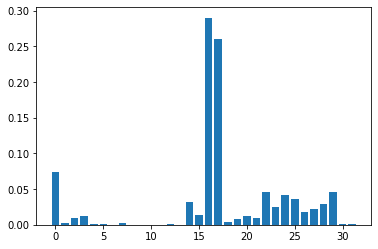

In [35]:
importance = rf_cv.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

According to the above model, the earlier diagnosis of a HPV(Human Papilloma Virus) infection has the maximum importance among other features in the Random Forest model.